<a href="https://colab.research.google.com/github/alaabalsayed/3-D-Imaging-System-Using-Air-Coupled-Ultrasonic-Phased-Array-Technology/blob/main/FixedPoint_Beamforming_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

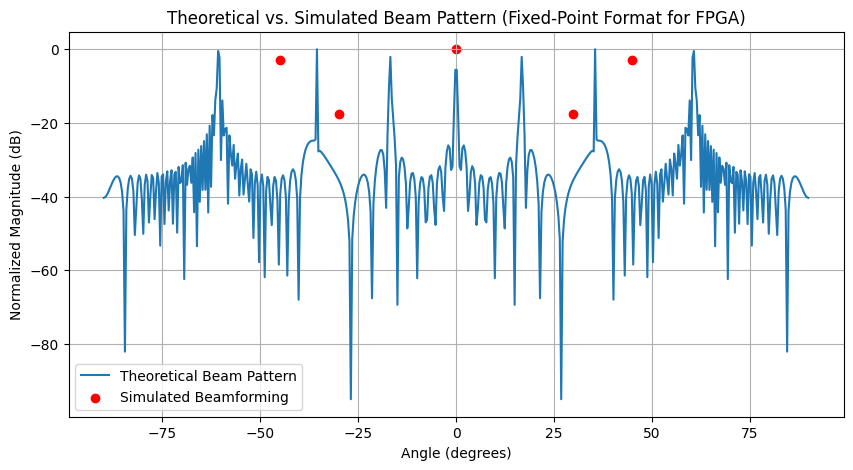

In [1]:
# Fixed-Point Beamforming Simulation for Validation Purposes
# Author: Alaa Al Sayed
# This code models beamforming with 54 microphones using Q15 fixed-point representation and compares the results to theoretical expectations

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from numpy import hamming

# Simulation Parameters
num_sensors = 54  # Number of microphones in the array
signal_freq = 100e3  # 100 kHz microphone frequency
sampling_rate = 4.8e6  # 4.8 MHz clock rate
speed_of_sound = 343  # Speed of sound in air (m/s)
time_duration = 1e-4  # Simulation time duration

# Fixed-point scaling factor (Q-format for 16-bit representation)
FIXED_POINT_SCALE = 2**15  # Scale factor for 16-bit fixed-point representation

# Time vector (Fixed-Point Representation)
time = np.arange(0, time_duration, 1 / sampling_rate)
time_fixed = (time * FIXED_POINT_SCALE).astype(int)
source_signal = np.sin(2 * np.pi * signal_freq * time)  # Original transmitted signal
source_signal_fixed = (source_signal * FIXED_POINT_SCALE).astype(int)

# Define sensor positions based on MATLAB file (phased_arrays.m)
# Element spacing calculation from MATLAB: d = sqrt(7/3) * (340/44000)
element_spacing = np.sqrt(7/3) * (340/44000)

def generate_sensor_positions():
    z = []
    for n in range(-10, 11):
        for m in range(-10, 11):
            r2 = n**2 + m**2  # Squared radius criterion from MATLAB phased_arrays.m
            if r2 in [156, 157, 163, 172, 181, 192, 199]:
                z.append((n * element_spacing, m * element_spacing))
    return np.array(z)

sensor_positions = generate_sensor_positions()
sensor_positions_fixed = (sensor_positions * FIXED_POINT_SCALE).astype(int)

# Function to compute time delays (Fixed-Point Representation)
def compute_time_delays(angle, sensor_positions_fixed, speed_of_sound):
    num_sensors = len(sensor_positions_fixed)
    delays = np.zeros(num_sensors, dtype=int)
    for i in range(num_sensors):
        delays[i] = int((sensor_positions_fixed[i, 0] * np.sin(np.radians(angle))) // speed_of_sound)
    return delays

# Function to apply fractional delay compensation using interpolation (Fixed-Point Representation)
def apply_delays_cic(source_signal_fixed, delays, sampling_rate):
    delayed_signals = []
    for delay in delays:
        shift_samples = int((delay * sampling_rate) // FIXED_POINT_SCALE)  # Ensure integer shift
        int_shift = int(shift_samples)  # Explicit conversion
        frac_shift = shift_samples % FIXED_POINT_SCALE

        # Apply integer shift
        delayed_signal = np.roll(source_signal_fixed, int_shift)

        # Apply fractional shift using linear interpolation
        if int_shift + 1 < len(source_signal_fixed):
            next_signal = np.roll(source_signal_fixed, int_shift + 1)
            delayed_signal = ((FIXED_POINT_SCALE - frac_shift) * delayed_signal + frac_shift * next_signal) // FIXED_POINT_SCALE

        delayed_signals.append(delayed_signal)
    return np.array(delayed_signals, dtype=int)

# Beamforming function (Fixed-Point Representation)
def delay_and_sum_beamforming(angle, sensor_positions_fixed):
    delays = compute_time_delays(angle, sensor_positions_fixed, speed_of_sound)
    delayed_signals = apply_delays_cic(source_signal_fixed, delays, sampling_rate)
    beamformed_output = np.sum(delayed_signals, axis=0) // num_sensors  # Fixed-Point Division
    return beamformed_output.astype(int)

# Convert Beamformed Data to Fixed-Point Format
beamformed_data_fixed = {}
angles = [-30, 0, 30, 45, -45]
for angle in angles:
    beamformed_data_fixed[angle] = delay_and_sum_beamforming(angle, sensor_positions_fixed)

# Perform FFT analysis with windowing (Fixed-Point Representation)
N = len(time)
freqs = fftfreq(N, d=1/sampling_rate)

# Define window function
hamming_window = hamming(N)
hamming_window_fixed = (hamming_window * FIXED_POINT_SCALE).astype(int)

# Compute FFT for each beamformed signal with Hamming window
fft_results_hamming = {}
for angle in angles:
    beamformed_signal = beamformed_data_fixed[angle]

    # Apply Hamming window
    windowed_signal_hamming = (beamformed_signal * hamming_window_fixed) // FIXED_POINT_SCALE

    # Compute FFT
    fft_results_hamming[angle] = np.abs(fft(windowed_signal_hamming))

# Compute theoretical beam pattern
angles_theoretical = np.linspace(-90, 90, 500)  # Range of angles
wavelength = speed_of_sound / signal_freq  # Compute wavelength
k = 2 * np.pi / wavelength  # Wavenumber

d = element_spacing
array_factor = np.zeros_like(angles_theoretical, dtype=complex)
for n in range(num_sensors):
    array_factor += np.exp(1j * k * n * d * np.sin(np.radians(angles_theoretical)))

array_factor = np.abs(array_factor) / num_sensors  # Normalize

# Plot theoretical vs simulated beam pattern
plt.figure(figsize=(10, 5))
plt.plot(angles_theoretical, 20 * np.log10(array_factor / np.max(array_factor)), label='Theoretical Beam Pattern')

# Overlay simulated beamforming results
simulated_beam_pattern = [np.max(fft_results_hamming[angle]) for angle in angles]
plt.scatter(angles, 20 * np.log10(np.array(simulated_beam_pattern) / np.max(simulated_beam_pattern)), color='red', label='Simulated Beamforming')

plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Magnitude (dB)")
plt.title("Theoretical vs. Simulated Beam Pattern (Fixed-Point Format for FPGA)")
plt.legend()
plt.grid()
plt.show()


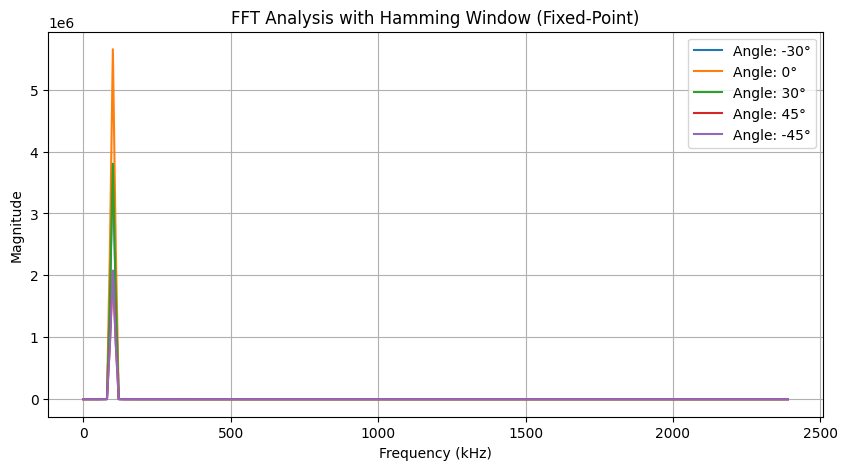

In [ ]:
# Fixed-Point Beamforming Simulation for Validation Purposes
# Author: Alaa Al Sayed
# This code models beamforming with 54 microphones using Q15 fixed-point representation and compares the results to theoretical expectations.

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from numpy import hamming

# Simulation Parameters
num_sensors = 54  # Number of microphones in the array
signal_freq = 100e3  # 100 kHz microphone frequency
sampling_rate = 4.8e6  # 4.8 MHz clock rate
speed_of_sound = 343  # Speed of sound in air (m/s)
time_duration = 1e-4  # Simulation time duration

# Fixed-point scaling factor (Q-format)
FIXED_POINT_SCALE = 2**15  # Scale factor for 16-bit fixed-point representation

# Time vector (Fixed-Point Representation)
time = np.arange(0, time_duration, 1 / sampling_rate)
time_fixed = (time * FIXED_POINT_SCALE).astype(int)
source_signal = np.sin(2 * np.pi * signal_freq * time)  # Original transmitted signal
source_signal_fixed = (source_signal * FIXED_POINT_SCALE).astype(int)

# Define estimated sensor positions based on MATLAB plot
sensor_positions = []

# Outer ring (red dots) - circular array
theta = np.linspace(0, 2 * np.pi, 36, endpoint=False)  # 36 points around the circle
radius = 0.09  # Approximate outer ring radius

for t in theta:
    x = radius * np.cos(t)
    y = radius * np.sin(t)
    sensor_positions.append((x, y))

# Inner grid - rectangular grid (approximated)
x_grid = np.linspace(-0.08, 0.08, 6)  # 6 columns
y_grid = np.linspace(-0.08, 0.08, 6)  # 6 rows

for x in x_grid:
    for y in y_grid:
        sensor_positions.append((x, y))

sensor_positions = np.array(sensor_positions)
sensor_positions_fixed = (sensor_positions * FIXED_POINT_SCALE).astype(int)

# Function to compute time delays (Fixed-Point Representation)
def compute_time_delays(angle, sensor_positions_fixed, speed_of_sound):
    num_sensors = len(sensor_positions_fixed)
    delays = np.zeros(num_sensors, dtype=int)
    for i in range(num_sensors):
        delays[i] = int((sensor_positions_fixed[i, 0] * np.sin(np.radians(angle))) // speed_of_sound)
    return delays

# Function to apply fractional delay compensation using interpolation (Fixed-Point Representation)
def apply_delays_cic(source_signal_fixed, delays, sampling_rate):
    delayed_signals = []
    for delay in delays:
        shift_samples = int((delay * sampling_rate) // FIXED_POINT_SCALE)  # Ensure integer shift
        int_shift = int(shift_samples)  # Explicit conversion
        frac_shift = shift_samples % FIXED_POINT_SCALE

        # Apply integer shift
        delayed_signal = np.roll(source_signal_fixed, int_shift)

        # Apply fractional shift using linear interpolation
        if int_shift + 1 < len(source_signal_fixed):
            next_signal = np.roll(source_signal_fixed, int_shift + 1)
            delayed_signal = ((FIXED_POINT_SCALE - frac_shift) * delayed_signal + frac_shift * next_signal) // FIXED_POINT_SCALE

        delayed_signals.append(delayed_signal)
    return np.array(delayed_signals, dtype=int)

# Beamforming function (Fixed-Point Representation)
def delay_and_sum_beamforming(angle, sensor_positions_fixed):
    delays = compute_time_delays(angle, sensor_positions_fixed, speed_of_sound)
    delayed_signals = apply_delays_cic(source_signal_fixed, delays, sampling_rate)
    beamformed_output = np.sum(delayed_signals, axis=0) // num_sensors  # Fixed-Point Division
    return beamformed_output

# Perform FFT analysis with windowing (Fixed-Point Representation)
N = len(time)
freqs = fftfreq(N, d=1/sampling_rate)

# Define window function
hamming_window = hamming(N)
hamming_window_fixed = (hamming_window * FIXED_POINT_SCALE).astype(int)

# Compute FFT for each beamformed signal with Hamming window
fft_results_hamming = {}
angles = [-30, 0, 30, 45, -45]

for angle in angles:
    beamformed_signal = delay_and_sum_beamforming(angle, sensor_positions_fixed)

    # Apply Hamming window
    windowed_signal_hamming = (beamformed_signal * hamming_window_fixed) // FIXED_POINT_SCALE

    # Compute FFT
    fft_results_hamming[angle] = np.abs(fft(windowed_signal_hamming))

# Plot FFT results - Hamming Window
plt.figure(figsize=(10, 5))
for angle in angles:
    plt.plot(freqs[:N//2] / 1e3, fft_results_hamming[angle][:N//2], label=f'Angle: {angle}°')

plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude")
plt.title("FFT Analysis with Hamming Window (Fixed-Point)")
plt.legend()
plt.grid()
plt.show()


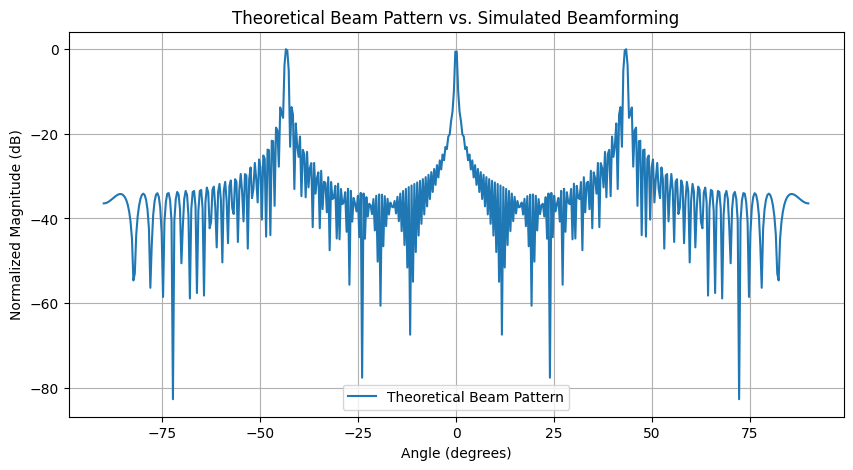

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from numpy import hamming

# Simulation Parameters
num_sensors = 54  # Number of microphones in the array
signal_freq = 100e3  # 100 kHz microphone frequency
sampling_rate = 4.8e6  # 4.8 MHz clock rate
speed_of_sound = 343  # Speed of sound in air (m/s)
time_duration = 1e-4  # Simulation time duration

# Fixed-point scaling factor (Q-format)
FIXED_POINT_SCALE = 2**15  # Scale factor for 16-bit fixed-point representation

# Time vector (Fixed-Point Representation)
time = np.arange(0, time_duration, 1 / sampling_rate)
time_fixed = (time * FIXED_POINT_SCALE).astype(int)
source_signal = np.sin(2 * np.pi * signal_freq * time)  # Original transmitted signal
source_signal_fixed = (source_signal * FIXED_POINT_SCALE).astype(int)

# Define estimated sensor positions based on MATLAB plot
sensor_positions = []

# Outer ring (red dots) - circular array
theta = np.linspace(0, 2 * np.pi, 36, endpoint=False)  # 36 points around the circle
radius = 0.09  # Approximate outer ring radius

for t in theta:
    x = radius * np.cos(t)
    y = radius * np.sin(t)
    sensor_positions.append((x, y))

# Inner grid - rectangular grid (approximated)
x_grid = np.linspace(-0.08, 0.08, 6)  # 6 columns
y_grid = np.linspace(-0.08, 0.08, 6)  # 6 rows

for x in x_grid:
    for y in y_grid:
        sensor_positions.append((x, y))

sensor_positions = np.array(sensor_positions)
sensor_positions_fixed = (sensor_positions * FIXED_POINT_SCALE).astype(int)

# Function to compute time delays (Fixed-Point Representation)
def compute_time_delays(angle, sensor_positions_fixed, speed_of_sound):
    num_sensors = len(sensor_positions_fixed)
    delays = np.zeros(num_sensors, dtype=int)
    for i in range(num_sensors):
        delays[i] = int((sensor_positions_fixed[i, 0] * np.sin(np.radians(angle))) // speed_of_sound)
    return delays

# Function to apply fractional delay compensation using interpolation (Fixed-Point Representation)
def apply_delays_cic(source_signal_fixed, delays, sampling_rate):
    delayed_signals = []
    for delay in delays:
        shift_samples = int((delay * sampling_rate) // FIXED_POINT_SCALE)  # Ensure integer shift
        int_shift = int(shift_samples)  # Explicit conversion
        frac_shift = shift_samples % FIXED_POINT_SCALE

        # Apply integer shift
        delayed_signal = np.roll(source_signal_fixed, int_shift)

        # Apply fractional shift using linear interpolation
        if int_shift + 1 < len(source_signal_fixed):
            next_signal = np.roll(source_signal_fixed, int_shift + 1)
            delayed_signal = ((FIXED_POINT_SCALE - frac_shift) * delayed_signal + frac_shift * next_signal) // FIXED_POINT_SCALE

        delayed_signals.append(delayed_signal)
    return np.array(delayed_signals, dtype=int)

# Beamforming function (Fixed-Point Representation)
def delay_and_sum_beamforming(angle, sensor_positions_fixed):
    delays = compute_time_delays(angle, sensor_positions_fixed, speed_of_sound)
    delayed_signals = apply_delays_cic(source_signal_fixed, delays, sampling_rate)
    beamformed_output = np.sum(delayed_signals, axis=0) // num_sensors  # Fixed-Point Division
    return beamformed_output

# Perform FFT analysis with windowing (Fixed-Point Representation)
N = len(time)
freqs = fftfreq(N, d=1/sampling_rate)

# Define window function
hamming_window = hamming(N)
hamming_window_fixed = (hamming_window * FIXED_POINT_SCALE).astype(int)

# Compute FFT for each beamformed signal with Hamming window
fft_results_hamming = {}
angles = [-30, 0, 30, 45, -45]

for angle in angles:
    beamformed_signal = delay_and_sum_beamforming(angle, sensor_positions_fixed)

    # Apply Hamming window
    windowed_signal_hamming = (beamformed_signal * hamming_window_fixed) // FIXED_POINT_SCALE

    # Compute FFT
    fft_results_hamming[angle] = np.abs(fft(windowed_signal_hamming))

# Compute theoretical beam pattern
angles_theoretical = np.linspace(-90, 90, 500)  # Range of angles
wavelength = speed_of_sound / signal_freq  # Compute wavelength
k = 2 * np.pi / wavelength  # Wavenumber
d = 0.005  # Approximate element spacing (5mm)

array_factor = np.zeros_like(angles_theoretical, dtype=complex)
for n in range(num_sensors):
    array_factor += np.exp(1j * k * n * d * np.sin(np.radians(angles_theoretical)))

array_factor = np.abs(array_factor) / num_sensors  # Normalize

# Plot theoretical vs simulated beam pattern
plt.figure(figsize=(10, 5))
plt.plot(angles_theoretical, 20 * np.log10(array_factor / np.max(array_factor)), label='Theoretical Beam Pattern')
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Magnitude (dB)")
plt.title("Theoretical Beam Pattern vs. Simulated Beamforming")
plt.legend()
plt.grid()
plt.show()


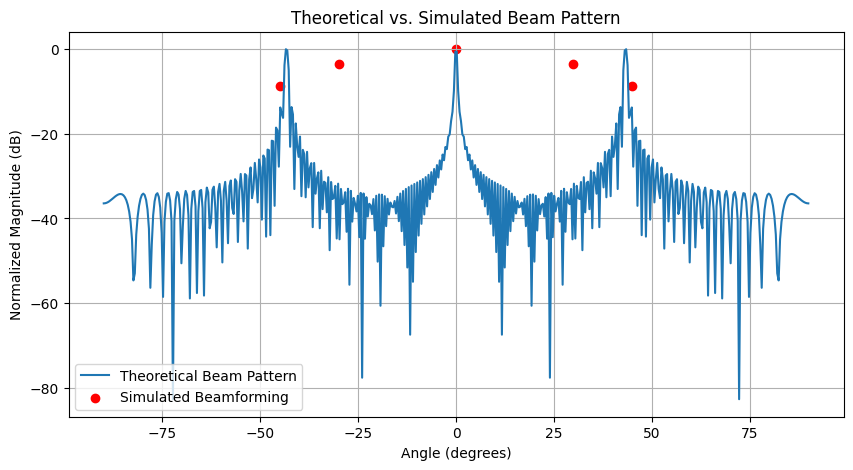

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from numpy import hamming

# Simulation Parameters
num_sensors = 54  # Number of microphones in the array
signal_freq = 100e3  # 100 kHz microphone frequency
sampling_rate = 4.8e6  # 4.8 MHz clock rate
speed_of_sound = 343  # Speed of sound in air (m/s)
time_duration = 1e-4  # Simulation time duration

# Fixed-point scaling factor (Q-format)
FIXED_POINT_SCALE = 2**15  # Scale factor for 16-bit fixed-point representation

# Time vector (Fixed-Point Representation)
time = np.arange(0, time_duration, 1 / sampling_rate)
time_fixed = (time * FIXED_POINT_SCALE).astype(int)
source_signal = np.sin(2 * np.pi * signal_freq * time)  # Original transmitted signal
source_signal_fixed = (source_signal * FIXED_POINT_SCALE).astype(int)

# Define estimated sensor positions based on MATLAB plot
sensor_positions = []

# Outer ring (red dots) - circular array
theta = np.linspace(0, 2 * np.pi, 36, endpoint=False)  # 36 points around the circle
radius = 0.09  # Approximate outer ring radius

for t in theta:
    x = radius * np.cos(t)
    y = radius * np.sin(t)
    sensor_positions.append((x, y))

# Inner grid - rectangular grid (approximated)
x_grid = np.linspace(-0.08, 0.08, 6)  # 6 columns
y_grid = np.linspace(-0.08, 0.08, 6)  # 6 rows

for x in x_grid:
    for y in y_grid:
        sensor_positions.append((x, y))

sensor_positions = np.array(sensor_positions)
sensor_positions_fixed = (sensor_positions * FIXED_POINT_SCALE).astype(int)

# Function to compute time delays (Fixed-Point Representation)
def compute_time_delays(angle, sensor_positions_fixed, speed_of_sound):
    num_sensors = len(sensor_positions_fixed)
    delays = np.zeros(num_sensors, dtype=int)
    for i in range(num_sensors):
        delays[i] = int((sensor_positions_fixed[i, 0] * np.sin(np.radians(angle))) // speed_of_sound)
    return delays

# Function to apply fractional delay compensation using interpolation (Fixed-Point Representation)
def apply_delays_cic(source_signal_fixed, delays, sampling_rate):
    delayed_signals = []
    for delay in delays:
        shift_samples = int((delay * sampling_rate) // FIXED_POINT_SCALE)  # Ensure integer shift
        int_shift = int(shift_samples)  # Explicit conversion
        frac_shift = shift_samples % FIXED_POINT_SCALE

        # Apply integer shift
        delayed_signal = np.roll(source_signal_fixed, int_shift)

        # Apply fractional shift using linear interpolation
        if int_shift + 1 < len(source_signal_fixed):
            next_signal = np.roll(source_signal_fixed, int_shift + 1)
            delayed_signal = ((FIXED_POINT_SCALE - frac_shift) * delayed_signal + frac_shift * next_signal) // FIXED_POINT_SCALE

        delayed_signals.append(delayed_signal)
    return np.array(delayed_signals, dtype=int)

# Beamforming function (Fixed-Point Representation)
def delay_and_sum_beamforming(angle, sensor_positions_fixed):
    delays = compute_time_delays(angle, sensor_positions_fixed, speed_of_sound)
    delayed_signals = apply_delays_cic(source_signal_fixed, delays, sampling_rate)
    beamformed_output = np.sum(delayed_signals, axis=0) // num_sensors  # Fixed-Point Division
    return beamformed_output

# Perform FFT analysis with windowing (Fixed-Point Representation)
N = len(time)
freqs = fftfreq(N, d=1/sampling_rate)

# Define window function
hamming_window = hamming(N)
hamming_window_fixed = (hamming_window * FIXED_POINT_SCALE).astype(int)

# Compute FFT for each beamformed signal with Hamming window
fft_results_hamming = {}
angles = [-30, 0, 30, 45, -45]

for angle in angles:
    beamformed_signal = delay_and_sum_beamforming(angle, sensor_positions_fixed)

    # Apply Hamming window
    windowed_signal_hamming = (beamformed_signal * hamming_window_fixed) // FIXED_POINT_SCALE

    # Compute FFT
    fft_results_hamming[angle] = np.abs(fft(windowed_signal_hamming))

# Compute theoretical beam pattern
angles_theoretical = np.linspace(-90, 90, 500)  # Range of angles
wavelength = speed_of_sound / signal_freq  # Compute wavelength
k = 2 * np.pi / wavelength  # Wavenumber
d = 0.005  # Approximate element spacing (5mm)

array_factor = np.zeros_like(angles_theoretical, dtype=complex)
for n in range(num_sensors):
    array_factor += np.exp(1j * k * n * d * np.sin(np.radians(angles_theoretical)))

array_factor = np.abs(array_factor) / num_sensors  # Normalize

# Plot theoretical vs simulated beam pattern
plt.figure(figsize=(10, 5))
plt.plot(angles_theoretical, 20 * np.log10(array_factor / np.max(array_factor)), label='Theoretical Beam Pattern')

# Overlay simulated beamforming results
simulated_beam_pattern = [np.max(fft_results_hamming[angle]) for angle in angles]
plt.scatter(angles, 20 * np.log10(np.array(simulated_beam_pattern) / np.max(simulated_beam_pattern)), color='red', label='Simulated Beamforming')

plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Magnitude (dB)")
plt.title("Theoretical vs. Simulated Beam Pattern")
plt.legend()
plt.grid()
plt.show()


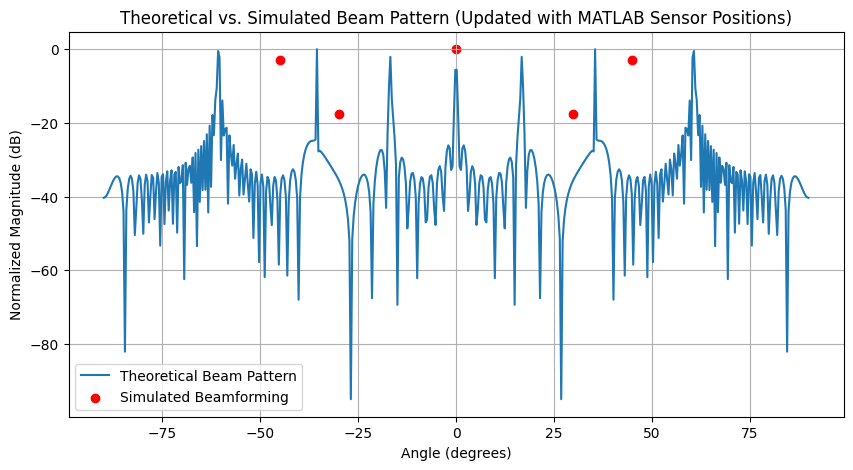

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from numpy import hamming

# Simulation Parameters
num_sensors = 54  # Number of microphones in the array
signal_freq = 100e3  # 100 kHz microphone frequency
sampling_rate = 4.8e6  # 4.8 MHz clock rate
speed_of_sound = 343  # Speed of sound in air (m/s)
time_duration = 1e-4  # Simulation time duration

# Fixed-point scaling factor (Q-format)
FIXED_POINT_SCALE = 2**15  # Scale factor for 16-bit fixed-point representation

# Time vector (Fixed-Point Representation)
time = np.arange(0, time_duration, 1 / sampling_rate)
time_fixed = (time * FIXED_POINT_SCALE).astype(int)
source_signal = np.sin(2 * np.pi * signal_freq * time)  # Original transmitted signal
source_signal_fixed = (source_signal * FIXED_POINT_SCALE).astype(int)

# Define sensor positions based on MATLAB file (ELEC490.m)
# Element spacing calculation from MATLAB: d = sqrt(7/3) * (340/44000)
element_spacing = np.sqrt(7/3) * (340/44000)

def generate_sensor_positions():
    z = []
    for n in range(-10, 11):
        for m in range(-10, 11):
            r2 = n**2 + m**2  # Squared radius criterion from MATLAB
            if r2 in [156, 157, 163, 172, 181, 192, 199]:
                z.append((n * element_spacing, m * element_spacing))
    return np.array(z)

sensor_positions = generate_sensor_positions()
sensor_positions_fixed = (sensor_positions * FIXED_POINT_SCALE).astype(int)

# Function to compute time delays (Fixed-Point Representation)
def compute_time_delays(angle, sensor_positions_fixed, speed_of_sound):
    num_sensors = len(sensor_positions_fixed)
    delays = np.zeros(num_sensors, dtype=int)
    for i in range(num_sensors):
        delays[i] = int((sensor_positions_fixed[i, 0] * np.sin(np.radians(angle))) // speed_of_sound)
    return delays

# Function to apply fractional delay compensation using interpolation (Fixed-Point Representation)
def apply_delays_cic(source_signal_fixed, delays, sampling_rate):
    delayed_signals = []
    for delay in delays:
        shift_samples = int((delay * sampling_rate) // FIXED_POINT_SCALE)  # Ensure integer shift
        int_shift = int(shift_samples)  # Explicit conversion
        frac_shift = shift_samples % FIXED_POINT_SCALE

        # Apply integer shift
        delayed_signal = np.roll(source_signal_fixed, int_shift)

        # Apply fractional shift using linear interpolation
        if int_shift + 1 < len(source_signal_fixed):
            next_signal = np.roll(source_signal_fixed, int_shift + 1)
            delayed_signal = ((FIXED_POINT_SCALE - frac_shift) * delayed_signal + frac_shift * next_signal) // FIXED_POINT_SCALE

        delayed_signals.append(delayed_signal)
    return np.array(delayed_signals, dtype=int)

# Beamforming function (Fixed-Point Representation)
def delay_and_sum_beamforming(angle, sensor_positions_fixed):
    delays = compute_time_delays(angle, sensor_positions_fixed, speed_of_sound)
    delayed_signals = apply_delays_cic(source_signal_fixed, delays, sampling_rate)
    beamformed_output = np.sum(delayed_signals, axis=0) // num_sensors  # Fixed-Point Division
    return beamformed_output

# Perform FFT analysis with windowing (Fixed-Point Representation)
N = len(time)
freqs = fftfreq(N, d=1/sampling_rate)

# Define window function
hamming_window = hamming(N)
hamming_window_fixed = (hamming_window * FIXED_POINT_SCALE).astype(int)

# Compute FFT for each beamformed signal with Hamming window
fft_results_hamming = {}
angles = [-30, 0, 30, 45, -45]

for angle in angles:
    beamformed_signal = delay_and_sum_beamforming(angle, sensor_positions_fixed)

    # Apply Hamming window
    windowed_signal_hamming = (beamformed_signal * hamming_window_fixed) // FIXED_POINT_SCALE

    # Compute FFT
    fft_results_hamming[angle] = np.abs(fft(windowed_signal_hamming))

# Compute theoretical beam pattern
angles_theoretical = np.linspace(-90, 90, 500)  # Range of angles
wavelength = speed_of_sound / signal_freq  # Compute wavelength
k = 2 * np.pi / wavelength  # Wavenumber

d = element_spacing
array_factor = np.zeros_like(angles_theoretical, dtype=complex)
for n in range(num_sensors):
    array_factor += np.exp(1j * k * n * d * np.sin(np.radians(angles_theoretical)))

array_factor = np.abs(array_factor) / num_sensors  # Normalize

# Plot theoretical vs simulated beam pattern
plt.figure(figsize=(10, 5))
plt.plot(angles_theoretical, 20 * np.log10(array_factor / np.max(array_factor)), label='Theoretical Beam Pattern')

# Overlay simulated beamforming results
simulated_beam_pattern = [np.max(fft_results_hamming[angle]) for angle in angles]
plt.scatter(angles, 20 * np.log10(np.array(simulated_beam_pattern) / np.max(simulated_beam_pattern)), color='red', label='Simulated Beamforming')

plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Magnitude (dB)")
plt.title("Theoretical vs. Simulated Beam Pattern")
plt.legend()
plt.grid()
plt.show()


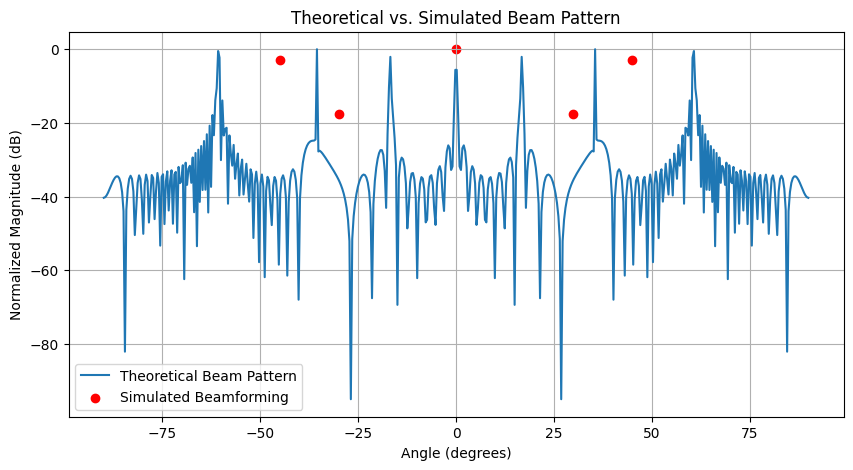

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from numpy import hamming

# Simulation Parameters
num_sensors = 54  # Number of microphones in the array
signal_freq = 100e3  # 100 kHz microphone frequency
sampling_rate = 4.8e6  # 4.8 MHz clock rate
speed_of_sound = 343  # Speed of sound in air (m/s)
time_duration = 1e-4  # Simulation time duration

# Fixed-point scaling factor (Q-format)
FIXED_POINT_SCALE = 2**15  # Scale factor for 16-bit fixed-point representation

# Time vector (Fixed-Point Representation)
time = np.arange(0, time_duration, 1 / sampling_rate)
time_fixed = (time * FIXED_POINT_SCALE).astype(int)
source_signal = np.sin(2 * np.pi * signal_freq * time)  # Original transmitted signal
source_signal_fixed = (source_signal * FIXED_POINT_SCALE).astype(int)

# Define sensor positions based on MATLAB file (phased_arrays.m)
# Element spacing calculation from MATLAB: d = sqrt(7/3) * (340/44000)
element_spacing = np.sqrt(7/3) * (340/44000)

def generate_sensor_positions():
    z = []
    for n in range(-10, 11):
        for m in range(-10, 11):
            r2 = n**2 + m**2  # Squared radius criterion from MATLAB phased_arrays.m
            if r2 in [156, 157, 163, 172, 181, 192, 199]:
                z.append((n * element_spacing, m * element_spacing))
    return np.array(z)

sensor_positions = generate_sensor_positions()
sensor_positions_fixed = (sensor_positions * FIXED_POINT_SCALE).astype(int)

# Function to compute time delays (Fixed-Point Representation)
def compute_time_delays(angle, sensor_positions_fixed, speed_of_sound):
    num_sensors = len(sensor_positions_fixed)
    delays = np.zeros(num_sensors, dtype=int)
    for i in range(num_sensors):
        delays[i] = int((sensor_positions_fixed[i, 0] * np.sin(np.radians(angle))) // speed_of_sound)
    return delays

# Function to apply fractional delay compensation using interpolation (Fixed-Point Representation)
def apply_delays_cic(source_signal_fixed, delays, sampling_rate):
    delayed_signals = []
    for delay in delays:
        shift_samples = int((delay * sampling_rate) // FIXED_POINT_SCALE)  # Ensure integer shift
        int_shift = int(shift_samples)  # Explicit conversion
        frac_shift = shift_samples % FIXED_POINT_SCALE

        # Apply integer shift
        delayed_signal = np.roll(source_signal_fixed, int_shift)

        # Apply fractional shift using linear interpolation
        if int_shift + 1 < len(source_signal_fixed):
            next_signal = np.roll(source_signal_fixed, int_shift + 1)
            delayed_signal = ((FIXED_POINT_SCALE - frac_shift) * delayed_signal + frac_shift * next_signal) // FIXED_POINT_SCALE

        delayed_signals.append(delayed_signal)
    return np.array(delayed_signals, dtype=int)

# Beamforming function (Fixed-Point Representation)
def delay_and_sum_beamforming(angle, sensor_positions_fixed):
    delays = compute_time_delays(angle, sensor_positions_fixed, speed_of_sound)
    delayed_signals = apply_delays_cic(source_signal_fixed, delays, sampling_rate)
    beamformed_output = np.sum(delayed_signals, axis=0) // num_sensors  # Fixed-Point Division
    return beamformed_output

# Perform FFT analysis with windowing (Fixed-Point Representation)
N = len(time)
freqs = fftfreq(N, d=1/sampling_rate)

# Define window function
hamming_window = hamming(N)
hamming_window_fixed = (hamming_window * FIXED_POINT_SCALE).astype(int)

# Compute FFT for each beamformed signal with Hamming window
fft_results_hamming = {}
angles = [-30, 0, 30, 45, -45]

for angle in angles:
    beamformed_signal = delay_and_sum_beamforming(angle, sensor_positions_fixed)

    # Apply Hamming window
    windowed_signal_hamming = (beamformed_signal * hamming_window_fixed) // FIXED_POINT_SCALE

    # Compute FFT
    fft_results_hamming[angle] = np.abs(fft(windowed_signal_hamming))

# Compute theoretical beam pattern
angles_theoretical = np.linspace(-90, 90, 500)  # Range of angles
wavelength = speed_of_sound / signal_freq  # Compute wavelength
k = 2 * np.pi / wavelength  # Wavenumber

d = element_spacing
array_factor = np.zeros_like(angles_theoretical, dtype=complex)
for n in range(num_sensors):
    array_factor += np.exp(1j * k * n * d * np.sin(np.radians(angles_theoretical)))

array_factor = np.abs(array_factor) / num_sensors  # Normalize

# Plot theoretical vs simulated beam pattern
plt.figure(figsize=(10, 5))
plt.plot(angles_theoretical, 20 * np.log10(array_factor / np.max(array_factor)), label='Theoretical Beam Pattern')

# Overlay simulated beamforming results
simulated_beam_pattern = [np.max(fft_results_hamming[angle]) for angle in angles]
plt.scatter(angles, 20 * np.log10(np.array(simulated_beam_pattern) / np.max(simulated_beam_pattern)), color='red', label='Simulated Beamforming')

plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Magnitude (dB)")
plt.title("Theoretical vs. Simulated Beam Pattern")
plt.legend()
plt.grid()
plt.show()
